# Random polymer
This example shows you how to run a simple polymer simulation in hoomdd.

Here is a script that generates a system of bead-spring polymers that self-assemble into a hex phase when run for a few million time steps. The polymers are A6B7A6 block copolymers in an implicit solvent. The script also shows a few examples of how writing python code in the script can be handy: here the concentration phi_P is a parameter and math operations are performed to calculate the length of the box.

For more information on the model in this script, see
"Micellar crystals in solution from molecular dynamics simulations"
J. Chem. Phys. 128, 184906 (2008); DOI:10.1063/1.2913522
http://link.aip.org/link/?JCPSA6/128/184906/1

Any of the polymer systems in the paper could be easily run just by changing a few parameters in this script.
from: https://lost-contact.mit.edu/afs//umich.edu/user/j/o/joaander/Public/hoomd-web/doc/page_example_scripts.html

## Initialize
First import hoomd and associated libraries and then initialize.  If no mode is given then the fastest processor cpu or gpu will be selected automatically.

In [1]:
import hoomd
from hoomd import *
from hoomd import md
from hoomd import deprecated
#context.initialize();
#hoomd.context.initialize("--mode=cpu");
hoomd.context.initialize("--mode=gpu");

HOOMD-blue v2.2.2-29-g1e86eec CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 
Compiled: 01/29/18
Copyright 2009-2017 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): This system is not compute exclusive, using local rank to select GPUs
notice(2): Unable to identify node local rank information
notice(2): Using global rank to select GPUs
HOOMD-blue is running on the following GPU(s):
 [0]  GeForce GTX 1060 6GB  10 SM_6.1 @ 1.84 GHz, 6075 MiB DRAM, DIS


## Import other libraries and define parameters

In [2]:
#import math
import math
# parameters (polymer physics)
phi_P = 0.25 # this has to do with how good of a solvent the polymer is in and is only used to calculate the box size below
n_poly = 1 # n_poly in the number of polymers in the simulation

## Define the polymer

In [3]:
# This polymer can be made up of two different types A and B.  It's called a block copolymer.
polymer1 = dict(bond_len=1.2, type=['B']*1 + ['A']*100 + ['B']*1,bond="linear", count=n_poly)
# perform some simple math to find the length of the box
N = len(polymer1['type']) * polymer1['count']
# generate the polymer system
system=deprecated.init.create_random_polymers(box=data.boxdim(volume=100*math.pi * N / (6.0 * phi_P)), polymers=[polymer1],separation=dict(A=0.35, B=0.35),seed=12)


notice(2): Group "all" created containing 102 particles


## Setup the bonds and force fields

In [4]:
# force field setup
harmonic = md.bond.harmonic()
harmonic.bond_coeff.set('polymer', k=330.0, r0=0.84)
nl = md.nlist.cell();
lj = md.pair.lj(r_cut=3.0,nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0, alpha=0.0)
lj.pair_coeff.set('A', 'B', epsilon=1.0, sigma=1.0, alpha=0.0)
lj.pair_coeff.set('B', 'B', epsilon=100.0, sigma=1.0, alpha=1.0)

## Integrate the simulation

In [5]:
import numpy
import math
# integrate NVT for a bunch of time steps
all = group.all()
md.integrate.mode_standard(dt=0.005)
md.integrate.nvt(group=all, kT=1.2, tau=0.5)

#save a gsd polymer configuration every 100 timesteps
dump.gsd("gsd/random_polymer_loop.gsd", period=100, group=all, overwrite=True);

#log position of particle 0
log = hoomd.analyze.log(filename="pxyz.log",
                         quantities=['p0x', 'p0y', 'p0z','plx','ply','plz','ree'],
                         period=100,
                         overwrite=True);
log.register_callback('p0x', lambda timestep: system.particles[0].position[0]);
log.register_callback('p0y', lambda timestep: system.particles[0].position[1]);
log.register_callback('p0z', lambda timestep: system.particles[0].position[2]);
log.register_callback('plx', lambda timestep: system.particles[101].position[0]);
log.register_callback('ply', lambda timestep: system.particles[101].position[1]);
log.register_callback('plz', lambda timestep: system.particles[101].position[2]);
log.register_callback('ree', lambda timestep: math.sqrt((log.query('p0x')-log.query('plx'))**2+(log.query('p0y')-log.query('ply'))**2+(log.query('p0z')-log.query('plz'))**2) );

#run(2000)
# uncomment the next run() command if you have a few hours to spare
# running this on a GPU the resulting dump files should show the
# polymers self-assembling into the hexagonal phase
run(10e6)
!head pxyz.log

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 1 exclusions             : 2
notice(2): Particles with 2 exclusions             : 100
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 165798 / 10000000 | TPS 16579.7 | ETA 00:09:53
Time 00:00:20 | Step 344238 / 10000000 | TPS 17843.9 | ETA 00:09:01
Time 00:00:30 | Step 516330 / 10000000 | TPS 17209.2 | ETA 00:09:11
Time 00:00:40 | Step 696860 / 10000000 | TPS 18053 | ETA 00:08:35
Time 00:00:50 | Step 875230 / 10000000 | TPS 17837 | ETA 00:08:31
Time 00:01:00 | Step 1058186 / 10000000 | TPS 18295.6 | ETA 00:08:08
Time 00:01:10 | Step 1237259 / 10000000 | TPS 17907.2 | ETA 00:08:09
Time 00:01:20 | Step 1414191 / 10000000 | TPS 17693.1 | ETA 00:08:05
Time 00:01:30 | Step 1589656 / 10000000 | TPS 17546.4 | ETA 00:07:59
Time 00:01:40 | Step 1765625 / 10000000 | TPS 17596.9 | ETA 00:07:47
Time 00:01:50 | Step 19

The results of this example may be visualized with VMD which can be installed from here: http://www.ks.uiuc.edu/Research/vmd/

In [6]:
#!vmd -e vdw.vmd gsd/random_polymer_loop.gsd

![](snapshots/random_polymer_loop.png)

In [7]:
!echo $PATH

/home/mattferguson/miniconda2/bin:/home/mattferguson/miniconda2/bin:/usr/local/cuda-8.0/bin:/home/mattferguson/bin:/home/mattferguson/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:NVIDIA_CUDA-8.0_Samples/bin/x86_64/linux/release/


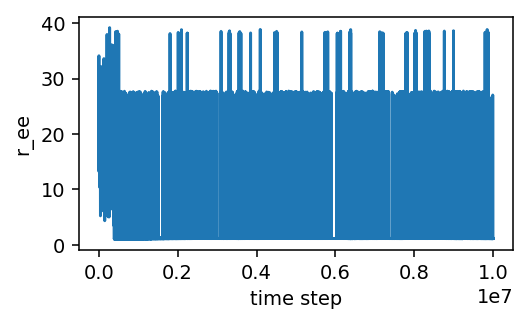

In [8]:
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='pxyz.log', skip_header=True);
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,7]);
pyplot.xlabel('time step');
pyplot.ylabel('r_ee');